In [1]:
import catboost

In [2]:
from lifelines.datasets import load_rossi

In [3]:
from lifelines import CoxPHFitter
from lifelines.datasets import load_rossi

In [4]:
rossi_df = load_rossi()

In [5]:
import numpy as np
from catboost import Pool, CatBoostRegressor

In [6]:
from time import sleep

In [7]:
class ProportionalLikelihood(object):
    reg = None
    
    def __init__(self, reg):
        self.reg = reg
        
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True
    
    def set_unique_time(self, t):
        t = t.copy()
        t = t.astype(float)
        for value in np.unique(t):
            t[t == value] += np.arange(t[t == value].shape[0]) / (100 * t[t == value].shape[0])
        return t

    def evaluate(self, h, t, sigma, der1_test=False, loss_test=False):
        t = self.set_unique_time(t)
        N = t.shape[0]
        
        initial_h = h[0] 
        h = np.exp(h[0])
        
        assert np.unique(t).shape[0] == t.shape[0], "All t should be unique"
        
        sorted_h = h[np.argsort(t)]
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1]
        eloss = (sorted_h / cumsum_h)
        
        reg_part = (initial_h ** 2).sum()
        
        loss_sum = -np.log(eloss).sum() + self.reg * reg_part
        
        if loss_test:
            return sorted_h, cumsum_h
        
        if der1_test:
            return loss_sum
        
        return loss_sum, N#np.sum(1 - sigma)#-np.log(loss).sum(), 
    
    def calc_ders_range(self, h, t, sigma, der1_test=False, der2_test=False):
        N = t.shape[0]
        t = self.set_unique_time(t)
        
        initial_h = h
        h = np.exp(h) # Possible math overflow!
        
        sorted_h_indices = np.argsort(t)
        rev_sorted_h_indices = np.argsort(sorted_h_indices)
        
        initial_sorted_h = initial_h[sorted_h_indices]
        sorted_h = h[sorted_h_indices] # hi
        cumsum_h = np.cumsum(sorted_h[::-1])[::-1] #Ci
        
        h_frac = 1 / sorted_h 
        cumsum_h_frac = 1 / cumsum_h 
        cumsum_h_frac_cumsum = np.cumsum(cumsum_h_frac)
        
        der1_part = (cumsum_h_frac_cumsum - h_frac)
        
        der1 = der1_part * sorted_h + 2 * self.reg * initial_sorted_h
        
        if der1_test:
            print(der1)
            return der1[rev_sorted_h_indices]
        
        h_frac_square = 1 / (sorted_h ** 2)
        cumsum_h_frac_square = 1 / (cumsum_h ** 2)
        cumsum_h_frac_square_cumsum = np.cumsum(cumsum_h_frac_square)
        
        der2_part = h_frac_square - cumsum_h_frac_square_cumsum
        
        der2 = sorted_h * (der1_part + der2_part * sorted_h) + self.reg * 2 * np.sign(initial_sorted_h)
        
        if der2_test:
            return der2[rev_sorted_h_indices]
        
        return np.vstack([
            -der1[rev_sorted_h_indices],
            -der2[rev_sorted_h_indices]
        ]).T

# Debugging derivatives

In [8]:
loss = ProportionalLikelihood(reg=0)

In [9]:
# Correct risk
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([3, 2, 1]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(0.32243617210995773, 3)

In [10]:
# One element is wrong
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(6.015889833080853, 3)

In [11]:
# Everything is incorrect
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([2, 3, 8]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [12]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 2, 3]), 
    np.array([0, 0, 0]),
#     loss_test=True
)

(11.015889833080852, 3)

In [13]:
loss.evaluate(
    (np.array([2, 3, 8]), ), 
    np.array([1, 0, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

11.011650169729464

In [14]:
delta = 0.001

In [15]:
# # First derivative, i=1
((loss.evaluate(
    (np.array([2 + delta, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)

-0.9975261843937488

In [16]:
# First derivative, i=2
((loss.evaluate(
    (np.array([2, -3 + delta, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


3.337823439863996e-05

In [17]:
# First derivative, i=3
((loss.evaluate(
    (np.array([2, -3, 8 + delta]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
) - loss.evaluate(
    (np.array([2, -3, 8]), ), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)) / delta)


0.9974953059481706

In [18]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 4, 2]), 
    np.array([0, 0, 0]),
    der1_test=True
)

[-9.97527418e-01  9.97494056e-01  3.33615481e-05]


array([-9.97527418e-01,  3.33615481e-05,  9.97494056e-01])

In [19]:
# Second derivative, i = 1
(
    loss.calc_ders_range(
        np.array([2 + delta, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[0] / delta

[-0.99752495 -0.99996664  1.99749159]
[-0.99752742 -0.99996664  1.99749406]


0.002467695841779083

In [20]:
# Second derivative, i = 2
(
    loss.calc_ders_range(
        np.array([2, -3 + delta, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[1] / delta

[-0.99752742 -0.99996661  1.99749402]
[-0.99752742 -0.99996664  1.99749406]


3.33776771777039e-05

In [21]:
# Second derivative, i = 3
(
    loss.calc_ders_range(
        np.array([2, -3, 8 + delta]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    ) - loss.calc_ders_range(
        np.array([2, -3, 8]), 
        np.array([0, 1, 2]), 
        np.array([0, 0, 0]),
        der1_test=True
    )
)[2] / delta

[-0.99752988 -0.99996667  1.99749655]
[-0.99752742 -0.99996664  1.99749406]


0.0024985036235491975

In [22]:
loss.calc_ders_range(
    np.array([2, -3, 8]), 
    np.array([0, 1, 2]), 
    np.array([0, 0, 0]),
    der2_test=True
)

array([2.46646830e-03, 3.33609916e-05, 2.49974691e-03])

### Difficult cases

In [23]:
# test_t = np.array([20, 17, 25, 23, 37, 25, 46, 28, 24, 50])
# test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
#  -2.33794021,  0.20124088, -0.42943875, -1.66655973])

test_t = np.array([20, 17, 25, 23, 37, 25.1, 46, 28])
test_h = np.array([ 1.0579772  , 1.3556235 ,  1.59537611 , 0.42585979 , 1.44649814 , 0.5426282,
 -2.33794021,  0.20124088])
test_sigma = np.zeros(test_t.shape[0])

In [24]:
np.argsort(test_t)

array([1, 0, 3, 2, 5, 7, 4, 6])

In [25]:
def get_numeric_derivative(h, t, sigma, i):
    h_increased = h.copy()
    h_increased[i] += delta
    
    return ((loss.evaluate(
        (h_increased, ), 
        t, 
        sigma,
        der1_test=True
    ) - loss.evaluate(
        (h, ), 
        t, 
        sigma,
        der1_test=True
    )) / delta)

In [26]:
np.array([get_numeric_derivative(test_h, test_t, test_sigma, i) for i in range(test_h.shape[0])])

array([-0.68620013, -0.81077798,  0.2993728 , -0.72182604,  2.44357478,
       -0.31033801,  0.07826807, -0.29005566])

In [27]:
loss.calc_ders_range(
    test_h, 
    test_t, 
    test_sigma,
#     der1_test=True
)

array([[ 0.68633213, -0.2639374 ],
       [ 0.81085468, -0.15336937],
       [-0.29894182, -0.8618662 ],
       [ 0.72195188, -0.25160388],
       [-2.44295454, -1.24041866],
       [ 0.31062828, -0.58041316],
       [-0.07822951, -0.0770924 ],
       [ 0.2903589 , -0.60634898]])

# Model

In [28]:
model = CatBoostRegressor(
    loss_function=loss, 
    eval_metric=loss, 
    iterations=1000, 
    learning_rate=0.01
)

In [29]:
N = 10000

In [30]:
rossi2_df = rossi_df[rossi_df['week'] < 52].iloc[0:N].reset_index(drop=True)

In [31]:
X = rossi2_df.drop(columns=['week'])

In [32]:
t = rossi2_df['week']

In [33]:
sigma = rossi2_df['arrest']

In [34]:
import numba

In [35]:
import matplotlib.pyplot as plt

/home/noomkcalb/anaconda3/lib/python3.7/site-packages/catboost/core.py:1913: UserWarning: Can't optimze method "calc_ders_range" because self argument is used
  _check_train_params(params)


0:	learn: 410.0969243	total: 55ms	remaining: 54.9s
1:	learn: 409.9896456	total: 64.7ms	remaining: 32.3s
2:	learn: 409.8872192	total: 72.7ms	remaining: 24.2s
3:	learn: 409.7391290	total: 78.8ms	remaining: 19.6s
4:	learn: 409.5834469	total: 83.3ms	remaining: 16.6s
5:	learn: 409.5070608	total: 87ms	remaining: 14.4s
6:	learn: 409.3994388	total: 90.3ms	remaining: 12.8s
7:	learn: 409.2246950	total: 93.5ms	remaining: 11.6s
8:	learn: 409.0941427	total: 96.2ms	remaining: 10.6s
9:	learn: 408.9443217	total: 98.9ms	remaining: 9.79s
10:	learn: 408.7768803	total: 102ms	remaining: 9.15s
11:	learn: 408.5832585	total: 104ms	remaining: 8.6s
12:	learn: 408.4778834	total: 107ms	remaining: 8.13s
13:	learn: 408.3262011	total: 110ms	remaining: 7.73s
14:	learn: 408.1875565	total: 112ms	remaining: 7.39s
15:	learn: 408.0121014	total: 115ms	remaining: 7.08s
16:	learn: 407.8499854	total: 118ms	remaining: 6.85s
17:	learn: 407.6858679	total: 121ms	remaining: 6.61s
18:	learn: 407.5592556	total: 124ms	remaining: 6.39

197:	learn: 392.0167266	total: 645ms	remaining: 2.61s
198:	learn: 391.9520295	total: 649ms	remaining: 2.61s
199:	learn: 391.8693421	total: 652ms	remaining: 2.61s
200:	learn: 391.7525841	total: 655ms	remaining: 2.6s
201:	learn: 391.6985810	total: 658ms	remaining: 2.6s
202:	learn: 391.6500593	total: 661ms	remaining: 2.59s
203:	learn: 391.6044926	total: 664ms	remaining: 2.59s
204:	learn: 391.5446381	total: 667ms	remaining: 2.58s
205:	learn: 391.4369791	total: 669ms	remaining: 2.58s
206:	learn: 391.3819530	total: 672ms	remaining: 2.58s
207:	learn: 391.2898315	total: 675ms	remaining: 2.57s
208:	learn: 391.2502568	total: 679ms	remaining: 2.57s
209:	learn: 391.1896966	total: 682ms	remaining: 2.56s
210:	learn: 391.1469252	total: 685ms	remaining: 2.56s
211:	learn: 391.0841030	total: 688ms	remaining: 2.56s
212:	learn: 391.0453054	total: 691ms	remaining: 2.55s
213:	learn: 390.9952632	total: 694ms	remaining: 2.55s
214:	learn: 390.9323443	total: 697ms	remaining: 2.54s
215:	learn: 390.8115523	total:

389:	learn: 381.7535366	total: 1.23s	remaining: 1.93s
390:	learn: 381.6840718	total: 1.24s	remaining: 1.92s
391:	learn: 381.6291543	total: 1.24s	remaining: 1.92s
392:	learn: 381.5399012	total: 1.24s	remaining: 1.92s
393:	learn: 381.4860998	total: 1.24s	remaining: 1.91s
394:	learn: 381.4378955	total: 1.25s	remaining: 1.91s
395:	learn: 381.3722925	total: 1.25s	remaining: 1.91s
396:	learn: 381.2795110	total: 1.25s	remaining: 1.9s
397:	learn: 381.2226133	total: 1.25s	remaining: 1.9s
398:	learn: 381.2011339	total: 1.26s	remaining: 1.9s
399:	learn: 381.1599616	total: 1.26s	remaining: 1.89s
400:	learn: 381.1123801	total: 1.26s	remaining: 1.89s
401:	learn: 381.0734382	total: 1.27s	remaining: 1.89s
402:	learn: 380.9884789	total: 1.27s	remaining: 1.88s
403:	learn: 380.9554961	total: 1.28s	remaining: 1.88s
404:	learn: 380.9176641	total: 1.28s	remaining: 1.88s
405:	learn: 380.8774948	total: 1.28s	remaining: 1.88s
406:	learn: 380.8231302	total: 1.28s	remaining: 1.87s
407:	learn: 380.7831461	total: 

580:	learn: 372.9463882	total: 1.82s	remaining: 1.31s
581:	learn: 372.9282017	total: 1.82s	remaining: 1.31s
582:	learn: 372.8863642	total: 1.83s	remaining: 1.31s
583:	learn: 372.8514059	total: 1.83s	remaining: 1.3s
584:	learn: 372.7886316	total: 1.83s	remaining: 1.3s
585:	learn: 372.7597300	total: 1.84s	remaining: 1.3s
586:	learn: 372.6939648	total: 1.84s	remaining: 1.29s
587:	learn: 372.6527442	total: 1.84s	remaining: 1.29s
588:	learn: 372.5968809	total: 1.84s	remaining: 1.29s
589:	learn: 372.5550786	total: 1.85s	remaining: 1.28s
590:	learn: 372.5020760	total: 1.85s	remaining: 1.28s
591:	learn: 372.4514153	total: 1.85s	remaining: 1.28s
592:	learn: 372.4108009	total: 1.86s	remaining: 1.27s
593:	learn: 372.3740121	total: 1.86s	remaining: 1.27s
594:	learn: 372.3298828	total: 1.86s	remaining: 1.27s
595:	learn: 372.3086740	total: 1.87s	remaining: 1.26s
596:	learn: 372.2701805	total: 1.87s	remaining: 1.26s
597:	learn: 372.2179205	total: 1.87s	remaining: 1.26s
598:	learn: 372.1598563	total: 

774:	learn: 365.9860373	total: 2.4s	remaining: 698ms
775:	learn: 365.9612142	total: 2.41s	remaining: 695ms
776:	learn: 365.9363788	total: 2.41s	remaining: 692ms
777:	learn: 365.8806025	total: 2.42s	remaining: 689ms
778:	learn: 365.8511529	total: 2.42s	remaining: 686ms
779:	learn: 365.8277347	total: 2.42s	remaining: 683ms
780:	learn: 365.8058312	total: 2.42s	remaining: 680ms
781:	learn: 365.7670618	total: 2.43s	remaining: 677ms
782:	learn: 365.7504012	total: 2.43s	remaining: 673ms
783:	learn: 365.7303011	total: 2.43s	remaining: 670ms
784:	learn: 365.7010140	total: 2.44s	remaining: 667ms
785:	learn: 365.6910174	total: 2.44s	remaining: 664ms
786:	learn: 365.6704780	total: 2.44s	remaining: 661ms
787:	learn: 365.6454207	total: 2.44s	remaining: 658ms
788:	learn: 365.5505027	total: 2.45s	remaining: 655ms
789:	learn: 365.5000215	total: 2.45s	remaining: 652ms
790:	learn: 365.4690150	total: 2.45s	remaining: 648ms
791:	learn: 365.4071631	total: 2.46s	remaining: 645ms
792:	learn: 365.3704238	total

971:	learn: 360.5877016	total: 3s	remaining: 86.4ms
972:	learn: 360.5454455	total: 3s	remaining: 83.3ms
973:	learn: 360.5196583	total: 3s	remaining: 80.2ms
974:	learn: 360.5067169	total: 3.01s	remaining: 77.1ms
975:	learn: 360.4623925	total: 3.01s	remaining: 74ms
976:	learn: 360.4491311	total: 3.01s	remaining: 70.9ms
977:	learn: 360.4147866	total: 3.01s	remaining: 67.8ms
978:	learn: 360.4022743	total: 3.02s	remaining: 64.7ms
979:	learn: 360.3903493	total: 3.02s	remaining: 61.6ms
980:	learn: 360.3468840	total: 3.02s	remaining: 58.6ms
981:	learn: 360.3298077	total: 3.03s	remaining: 55.5ms
982:	learn: 360.3083816	total: 3.03s	remaining: 52.4ms
983:	learn: 360.2652939	total: 3.03s	remaining: 49.3ms
984:	learn: 360.1796626	total: 3.04s	remaining: 46.2ms
985:	learn: 360.1341392	total: 3.04s	remaining: 43.2ms
986:	learn: 360.1018234	total: 3.04s	remaining: 40.1ms
987:	learn: 360.0729849	total: 3.04s	remaining: 37ms
988:	learn: 360.0558147	total: 3.05s	remaining: 33.9ms
989:	learn: 360.0368526

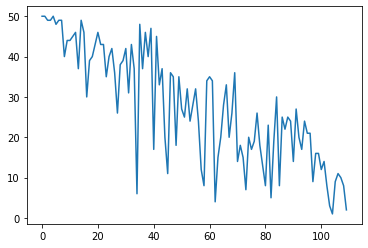

In [36]:
for i in range(0, 1):
    if i == 0:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True)
    else:
        model.fit(X, t, sample_weight=sigma, verbose_eval=True, init_model=model)
    prediction = model.predict(X)
    
    print(t.values, prediction)
    
    t[np.argsort(prediction)].reset_index(drop=True).plot()
    plt.show()

# Survival curve

In [37]:
def calculate_base_risk(h, t):
    d = np.arange(t.shape[0]) + 1
    cumsum_h = np.cumsum(h[::-1])[::-1]
    
    return d / cumsum_h

In [38]:
def get_unique_time(t):
    t = t.copy()
    t = t.astype(float)
    for value in np.unique(t):
        t[t == value] += np.arange(t[t == value].shape[0]) / (100 * t[t == value].shape[0])
    return t

In [40]:
train_h = np.exp(model.predict(X))
train_t = get_unique_time(t)

In [50]:
sorted_indices = np.argsort(train_t)

In [51]:
sorted_train_t = train_t[sorted_indices]
sorted_train_h = train_h[sorted_indices]

In [66]:
h_base = calculate_base_risk(sorted_train_h, sorted_train_t)

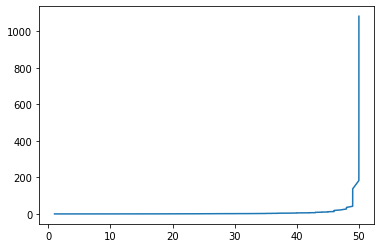

In [67]:
plt.plot(sorted_train_t, h_base)

In [68]:
H_base = -np.cumsum(h_base)

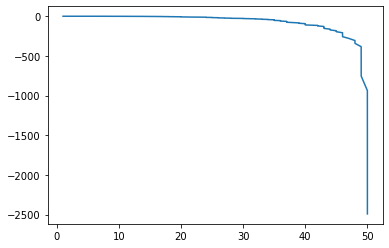

In [69]:
plt.plot(sorted_train_t, H_base)

In [70]:
S_base = np.exp(H_base)

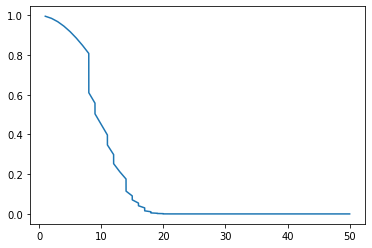

In [71]:
plt.plot(sorted_train_t, S_base)

In [76]:
S_matrix = S_base.reshape(1, -1) ** sorted_train_h.reshape(-1, 1)

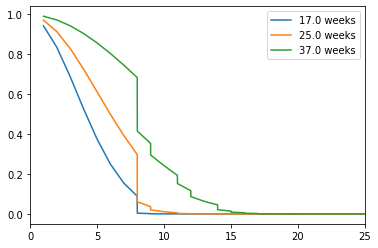

In [92]:
plt.plot(sorted_train_t, S_matrix[1], label=str(sorted_train_t[1]) + " weeks")
plt.plot(sorted_train_t, S_matrix[2], label=str(sorted_train_t[2]) + " weeks")
plt.plot(sorted_train_t, S_matrix[4], label=str(sorted_train_t[4]) + " weeks")
plt.xlim(0, 25)
plt.legend()